In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# load dataset
df = pd.read_json('archive\prices_2022.json')

In [4]:
df = df.set_index('date')
df = df.drop('trading_code', axis = 1)
df.head()

,last_traded_price,high,low,opening_price,closing_price,yesterdays_closing_price,trade,value_mn,volume
date,,,,,,,,,
2022-12-29,0.0,0.0,0.0,0.0,6.1,6.1,0,0.000,0
2022-12-28,6.1,6.1,6.1,6.1,6.1,6.1,1,0.001,100
2022-12-27,0.0,0.0,0.0,0.0,6.1,6.1,0,0.000,0
2022-12-26,6.1,6.1,6.1,6.1,6.1,6.1,3,0.001,205
2022-12-22,6.1,6.1,6.1,6.1,6.1,6.1,3,0.000,7


In [5]:
# import necessary libraries for LSTM
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten


In [6]:
x= df.drop('closing_price', axis = True)
y = df[['closing_price']]

In [7]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.2)
result = y_test
scaler = MinMaxScaler()
scaler.fit(y_train)
y_train =scaler.transform(y_train) # we transform the y so after predict we have to inverse transeform it
scaler.fit(y_test)
y_test =scaler.transform(y_test) # we transform the y so after predict we have to inverse transeform it

In [8]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(90171, 8, 1)
(22543, 8, 1)
(90171, 1)
(22543, 1)


In [9]:
# define the model
model = Sequential()
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mse')

history = model.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_test, y_test), verbose = 1)


Epoch 1/50
2818/2818 [==============================] - 30s 9ms/step - loss: 0.0029 - val_loss: 0.2379
Epoch 2/50
2818/2818 [==============================] - 24s 9ms/step - loss: 4.8878e-04 - val_loss: 0.2412
Epoch 3/50
2818/2818 [==============================] - 24s 9ms/step - loss: 3.4171e-04 - val_loss: 0.2383
Epoch 4/50
2818/2818 [==============================] - 24s 9ms/step - loss: 3.4830e-04 - val_loss: 0.2493
Epoch 5/50
2818/2818 [==============================] - 24s 9ms/step - loss: 3.2429e-04 - val_loss: 0.2410
Epoch 6/50
2818/2818 [==============================] - 24s 9ms/step - loss: 3.2955e-04 - val_loss: 0.2477
Epoch 7/50
2818/2818 [==============================] - 25s 9ms/step - loss: 3.2974e-04 - val_loss: 0.2419
Epoch 8/50
2818/2818 [==============================] - 24s 9ms/step - loss: 3.2175e-04 - val_loss: 0.2407
Epoch 9/50
2818/2818 [==============================] - 27s 9ms/step - loss: 3.2175e-04 - val_loss: 0.2415
Epoch 10/50
2818/2818 [==================

In [10]:
# model evaluation
loss = model.evaluate(x_test, y_test)
print('Test loss: ', loss)

705/705 [==============================] - 2s 3ms/step - loss: 0.2418
Test loss:  0.24184086918830872


In [11]:
# make predictions
predictions = model.predict(x_test)
output = scaler.inverse_transform(predictions)
output


705/705 [==============================] - 3s 3ms/step


array([[509871.12],
       [509876.38],
       [509875.22],
       ...,
       [509932.34],
       [512515.3 ],
       [509880.88]], dtype=float32)

In [12]:
real_output = []
for item in output:
    real_output.append((item[0]))

result['predited value'] = np.array(real_output)
result.head()

,closing_price,predited value
date,,
2022-07-27,271.70,509871.12500
2022-10-23,518.70,509876.37500
2022-07-27,162.50,509875.21875
2022-12-04,115.19,512515.18750
2022-08-24,208.00,509869.81250


<Axes: xlabel='date'>

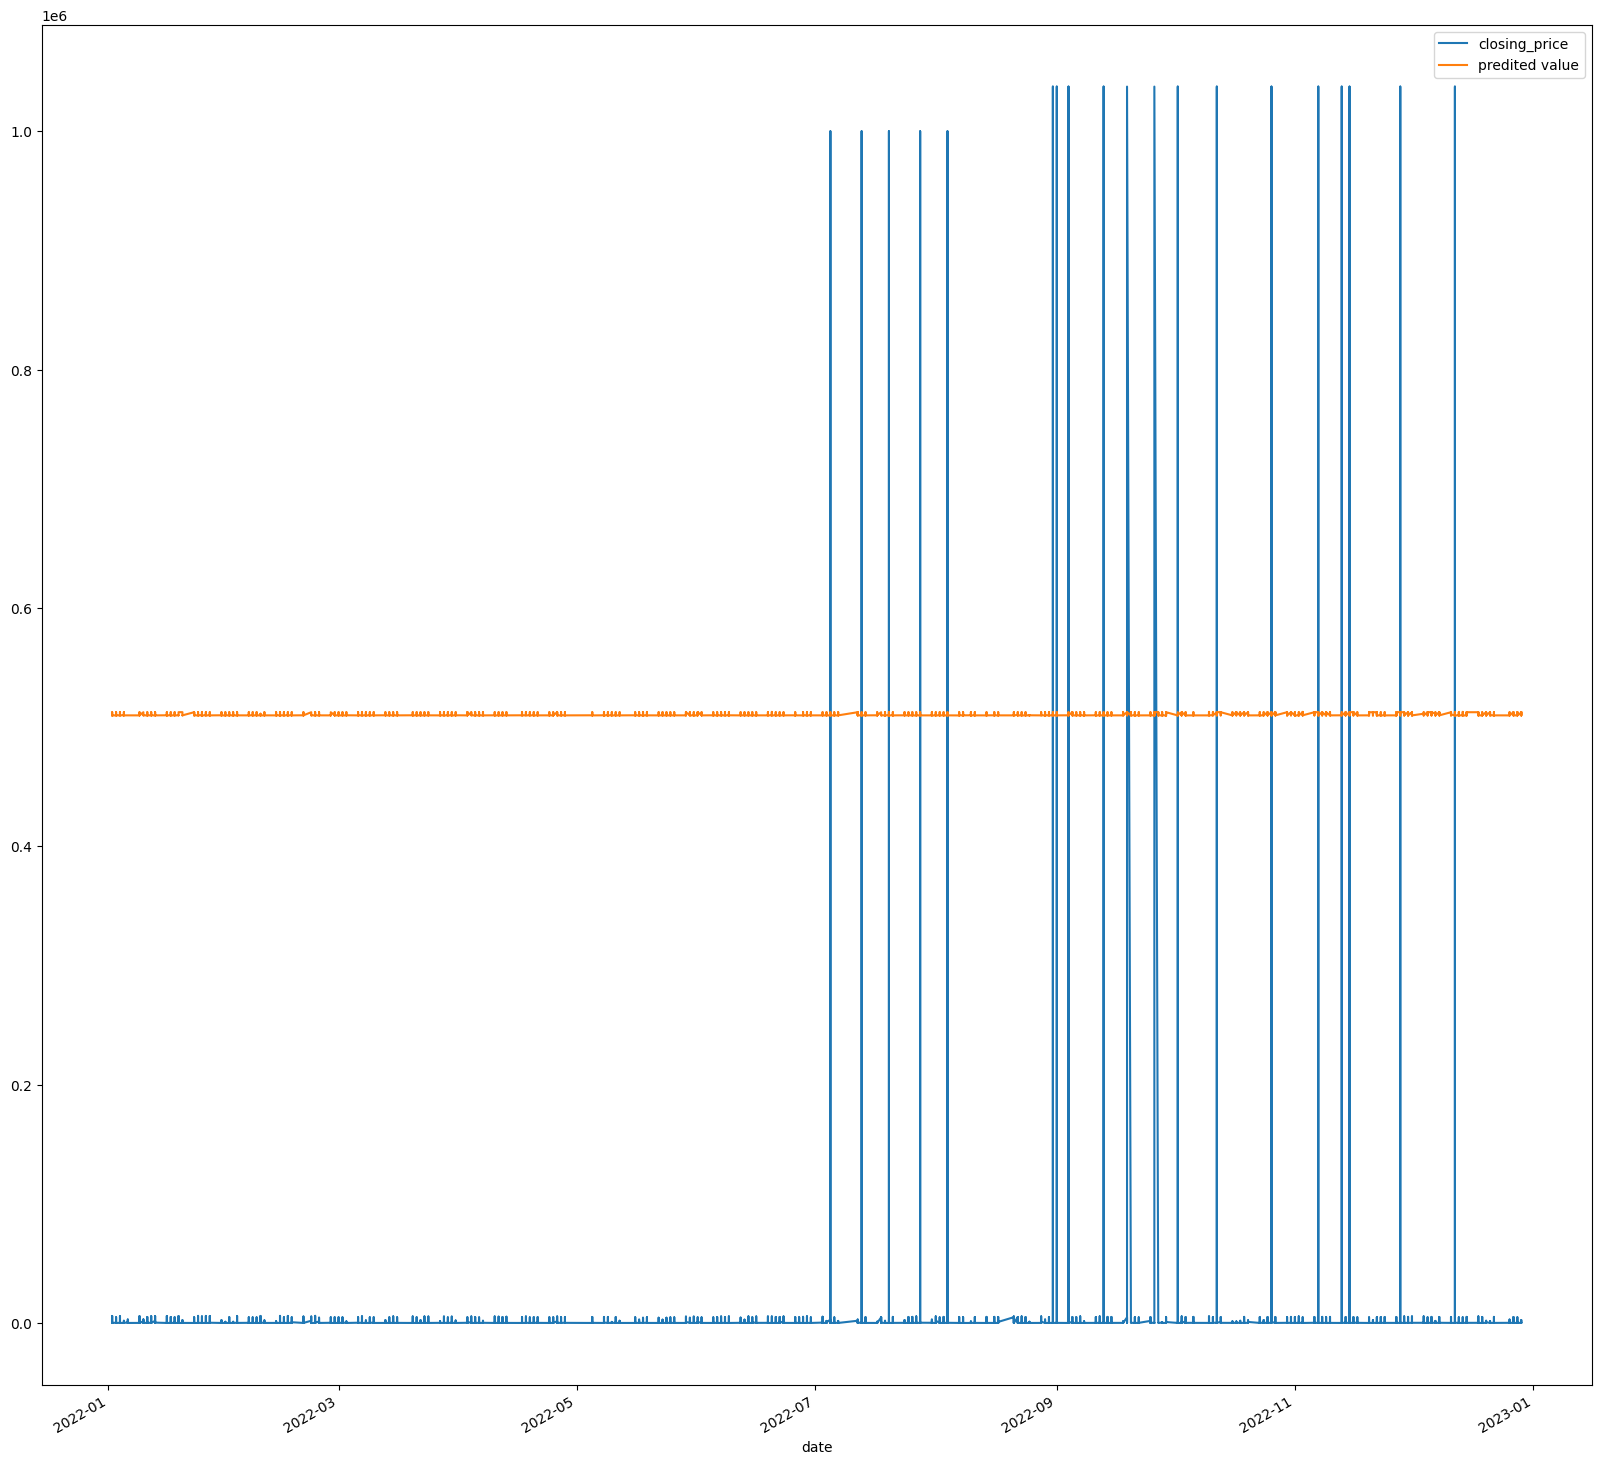

In [13]:
plt.rcParams["figure.figsize"] = (20,20)
result.plot()

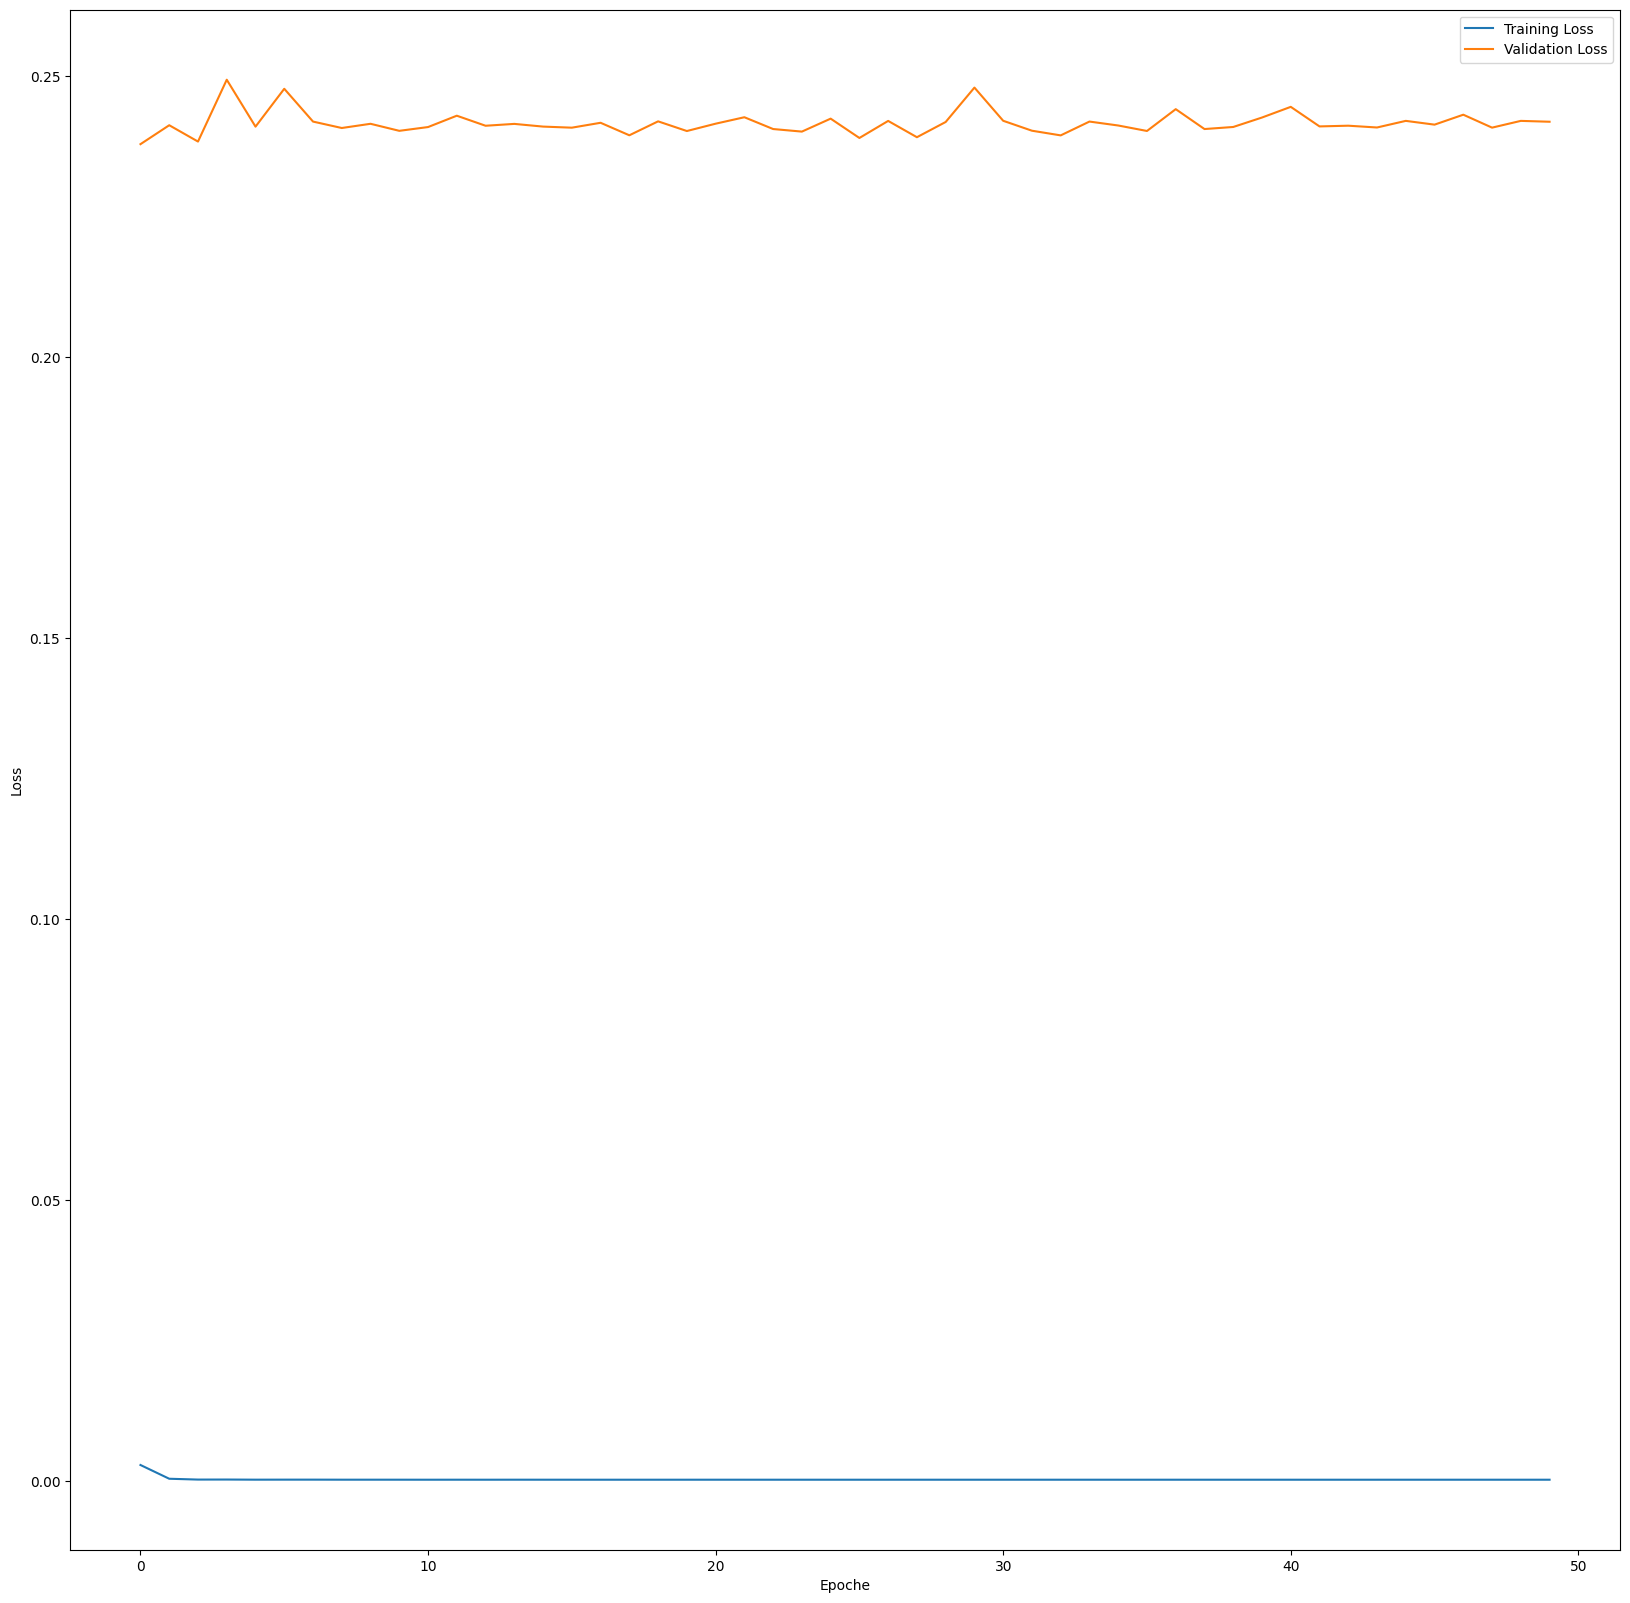

In [14]:
# plotting training and testing loss
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.show()

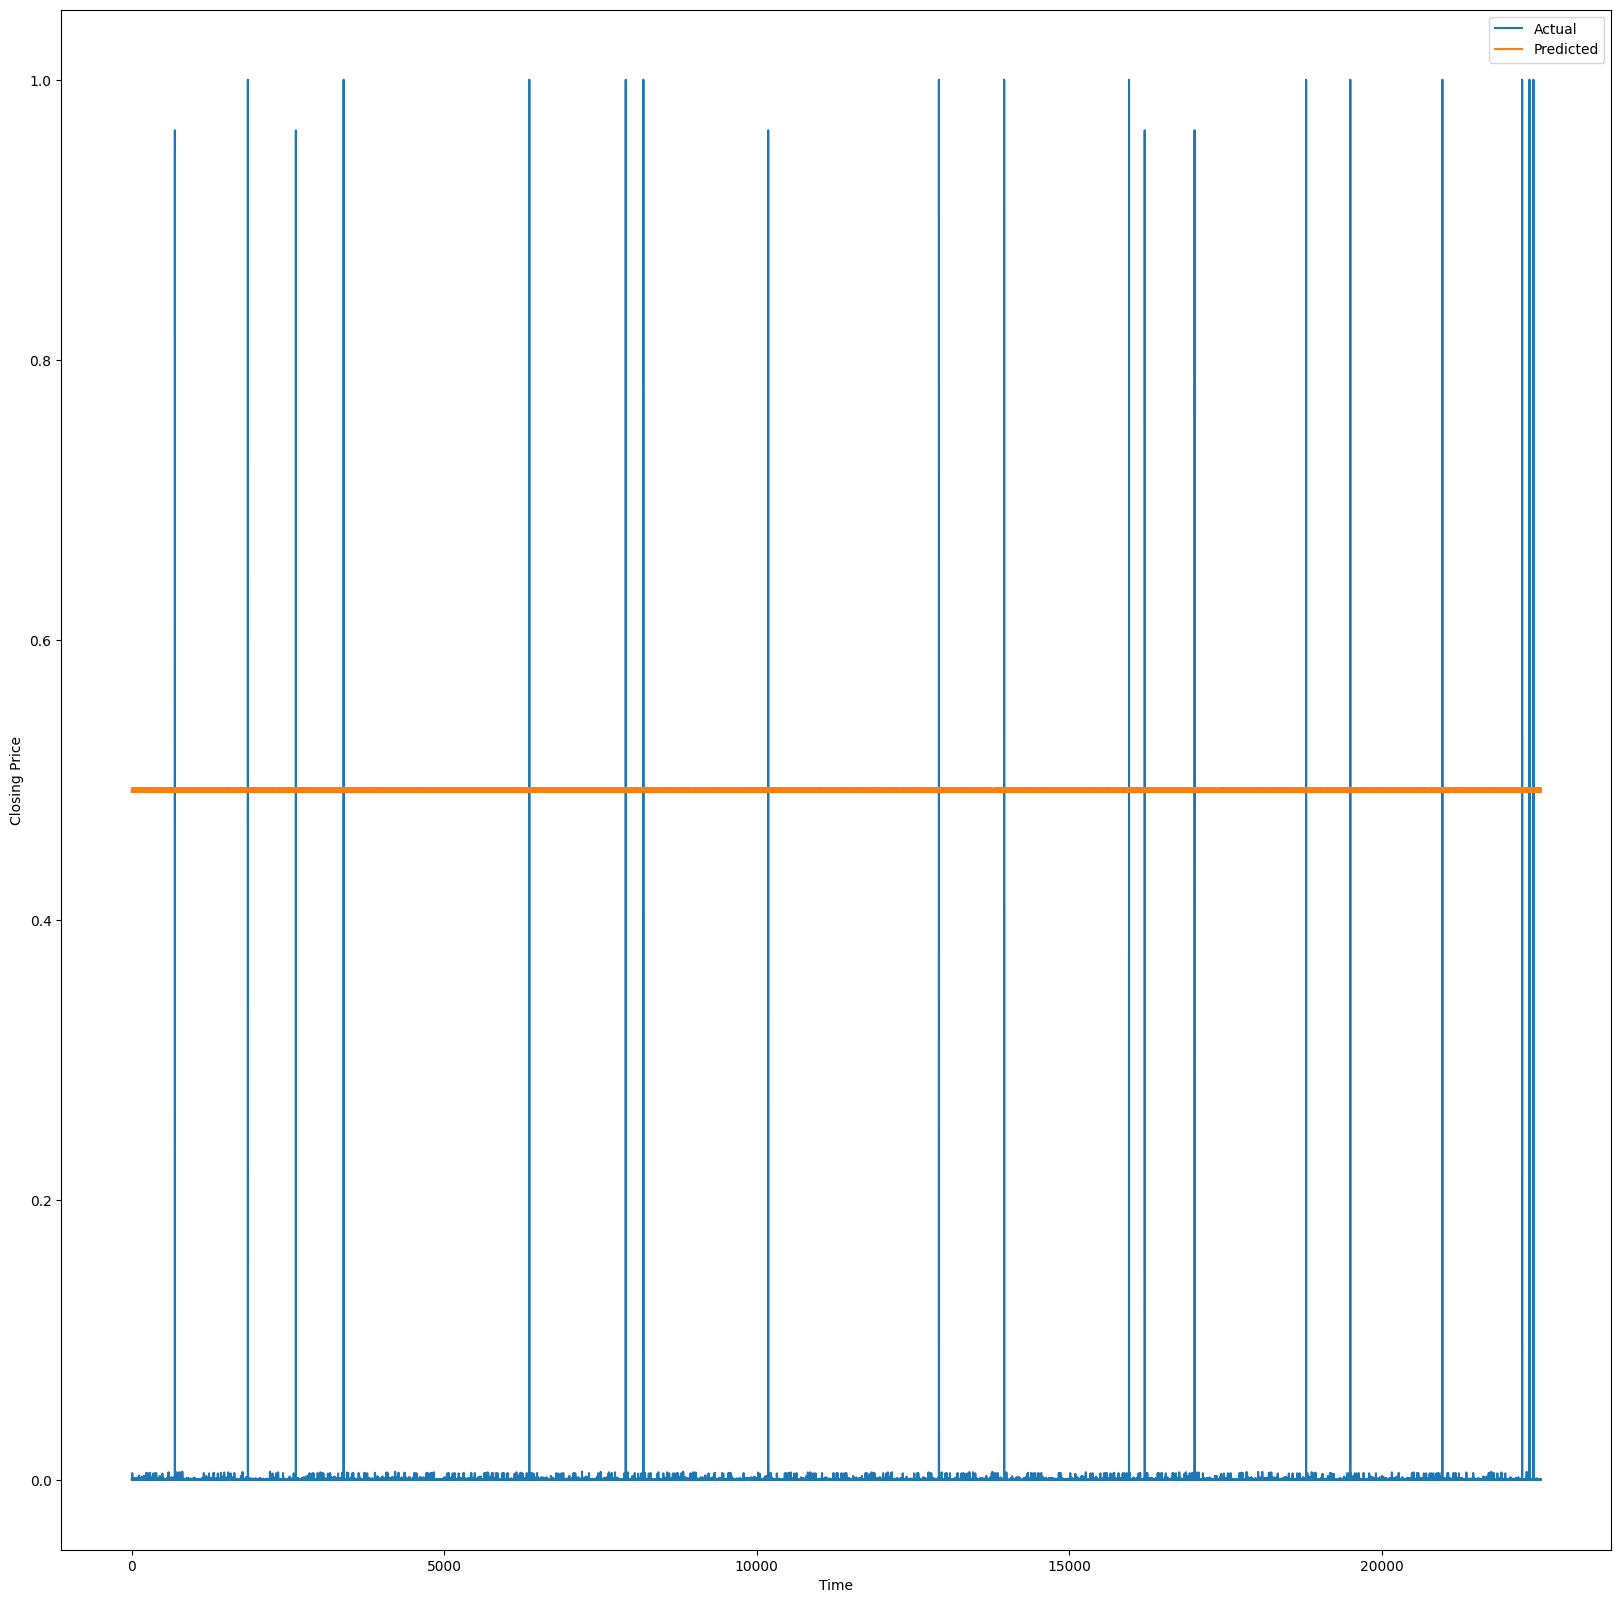

In [15]:
# plotting the actual vs predicted value
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show() 